In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Step 1: Fetch historical data for selected assets
# Assets chosen: 10-year Treasury bond (proxy for bonds), gold (GLD), Bitcoin (BTC-USD), and real estate (VNQ)
assets = ["^TNX", "GLD", "BTC-USD", "VNQ"]
data = yf.download(assets, start="2018-01-01", end="2023-01-01")['Adj Close']


[*********************100%***********************]  4 of 4 completed


In [17]:
# Step 2: Calculate daily returns from the price data
# Percentage change is calculated to represent daily returns
returns = data.pct_change().dropna()


/var/folders/s_/c_0m6c452k1g0x0q31jth99c0000gn/T/ipykernel_65360/68316138.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


In [18]:
# Step 3: Simulate a "Private Credit" asset
# Generate synthetic returns for Private Credit as a low-volatility, stable asset
np.random.seed(0)  # Ensure reproducibility of results
private_credit_returns = np.random.normal(0.00015, 0.001, len(returns))  # ~0.015% mean daily return
returns['Private Credit'] = private_credit_returns


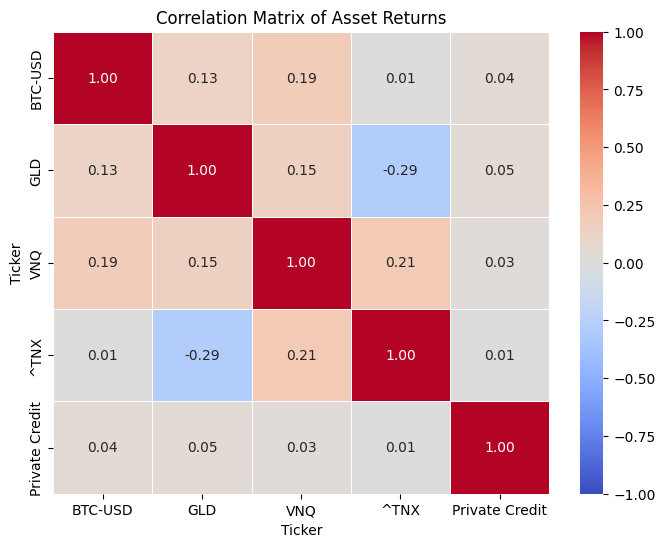

Correlation Matrix:
Ticker           BTC-USD       GLD       VNQ      ^TNX  Private Credit
Ticker                                                                
BTC-USD         1.000000  0.128399  0.191344  0.014160        0.041015
GLD             0.128399  1.000000  0.150670 -0.285425        0.045744
VNQ             0.191344  0.150670  1.000000  0.206982        0.026769
^TNX            0.014160 -0.285425  0.206982  1.000000        0.006998
Private Credit  0.041015  0.045744  0.026769  0.006998        1.000000


In [19]:
# Step 4: Compute the correlation matrix of asset returns
correlation_matrix = returns.corr()

# Step 5: Plot the correlation matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Asset Returns")
plt.show()

# You can also print the correlation matrix to the console
print("Correlation Matrix:")
print(correlation_matrix)

In [20]:
# Step 6: Calculate annualized returns and the covariance matrix
# Annualized returns assume 252 trading days in a year
mean_returns = returns.mean() * 252  # Mean daily returns annualized
cov_matrix = returns.cov() * 252    # Covariance matrix annualized

# Set the risk-free rate (e.g., yield on a risk-free asset like Treasury bonds)
risk_free_rate = 0.02  # 2% annualized risk-free return

# Define target return and volatility to mimic an S&P 500-like risk profile
target_volatility = 0.178  # ~17% annualized volatility
target_return = 0.11      # ~11% annualized return


In [21]:
# Step 7: Define a function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    """
    Calculate portfolio return and volatility for a given set of weights.
    """
    returns = np.sum(mean_returns * weights)  # Weighted average return
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Portfolio volatility
    return returns, volatility

# Step 8: Define the objective function for optimization
def objective_function(weights, mean_returns, cov_matrix, target_return, target_volatility):
    """
    Objective function to maximize the Sharpe ratio while penalizing concentration.
    """
    # Calculate portfolio returns and volatility
    returns, volatility = portfolio_performance(weights, mean_returns, cov_matrix)

    # Calculate Sharpe ratio
    sharpe_ratio = (returns - risk_free_rate) / volatility

    # Add a concentration penalty to avoid over-concentration in a few assets
    concentration_penalty = np.sum(weights**2)  # Penalizes high concentration
    penalty_factor = 10  # Adjustable factor for the penalty strength

    # Return the negative of the Sharpe ratio (we're minimizing)
    return -sharpe_ratio + penalty_factor * concentration_penalty


In [22]:
# Step 9: Define constraints
constraints = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights must sum to 1
    {'type': 'ineq', 'fun': lambda x: target_return - np.sum(mean_returns * x)},  # Return >= target return
    {'type': 'ineq', 'fun': lambda x: target_volatility - np.sqrt(np.dot(x.T, np.dot(cov_matrix, x)))},  # Volatility <= target volatility
)


In [23]:
# Step 10: Define initial guess and bounds for optimization
num_assets = len(mean_returns)
initial_guess = num_assets * [1. / num_assets,]  # Equal allocation as the starting point
bounds = tuple((0, 1) for _ in range(num_assets))  # Long-only portfolio (weights between 0 and 1)


In [24]:
# Step 9: Perform the optimization
result = minimize(objective_function,initial_guess,args=(mean_returns, cov_matrix, target_return, target_volatility),method='SLSQP',constraints=constraints)


In [25]:
# Extract the optimized weights
optimized_weights = result.x

# Step 10: Calculate portfolio performance with optimized weights
opt_returns, opt_volatility = portfolio_performance(optimized_weights, mean_returns, cov_matrix)
opt_sharpe_ratio = (opt_returns - risk_free_rate) / opt_volatility


In [26]:
# Additional Risk Metrics
# Value at Risk (VaR)
def calculate_value_at_risk(returns, weights, confidence_level=0.95):
    """
    Calculate Value at Risk (VaR) at a given confidence level.
    """
    portfolio_returns = returns.dot(weights)
    var = -np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    return var

# Conditional Value at Risk (CVaR)
def calculate_cvar(returns, weights, confidence_level=0.95):
    """
    Calculate Conditional Value at Risk (CVaR).
    """
    portfolio_returns = returns.dot(weights)
    var = calculate_value_at_risk(returns, weights, confidence_level)
    cvar = -portfolio_returns[portfolio_returns <= -var].mean()
    return cvar

# Max Drawdown
def calculate_max_drawdown(portfolio_returns):
    """
    Calculate the maximum drawdown of the portfolio.
    """
    cumulative_returns = (1 + portfolio_returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

In [27]:
# Calculate additional risk metrics
portfolio_returns = returns.dot(optimized_weights)  # Portfolio daily returns
value_at_risk = calculate_value_at_risk(returns, optimized_weights)
conditional_var = calculate_cvar(returns, optimized_weights)
max_drawdown = calculate_max_drawdown(portfolio_returns)

In [28]:
# Display optimized weights and portfolio performance
portfolio_weights = pd.DataFrame({'Asset': mean_returns.index, 'Weight': optimized_weights})
print("Optimized Portfolio Weights:")
print(portfolio_weights)
print("\nExpected Annual Return:", round(opt_returns * 100, 2), "%")
print("Expected Annual Volatility:", round(opt_volatility * 100, 2), "%")
print("Sharpe Ratio:", round(opt_sharpe_ratio, 2))
print("Value at Risk (95%):", round(value_at_risk, 4))
print("Conditional VaR (95%):", round(conditional_var, 4))
print("Maximum Drawdown:", round(max_drawdown, 4))

Optimized Portfolio Weights:
            Asset    Weight
0         BTC-USD  0.190365
1             GLD  0.207121
2             VNQ  0.193629
3            ^TNX  0.204854
4  Private Credit  0.204032

Expected Annual Return: 10.45 %
Expected Annual Volatility: 17.44 %
Sharpe Ratio: 0.48
Value at Risk (95%): 0.0153
Conditional VaR (95%): 0.0251
Maximum Drawdown: -0.2901


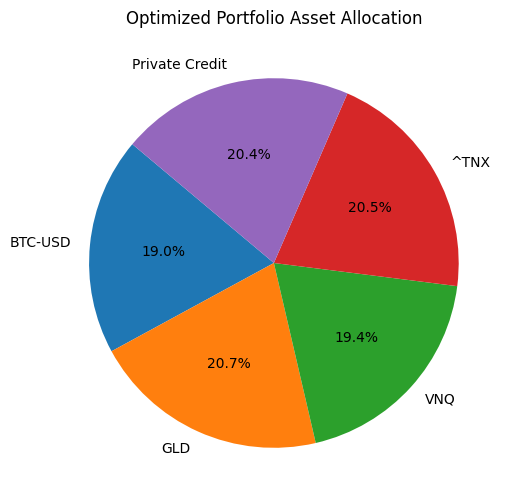

In [29]:
# Visualization: Plot pie chart of asset allocation
plt.figure(figsize=(10, 6))
plt.pie(optimized_weights, labels=mean_returns.index, autopct='%1.1f%%', startangle=140)
plt.title("Optimized Portfolio Asset Allocation")
plt.show()
